In [3]:
#!pip install d2l==1.0.3

'it has a mather and the pe'

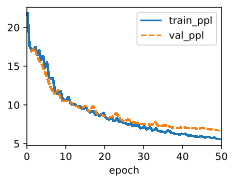

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

#############
# Lecture 8 #
#############

class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)   # H, C = H_C
    def forward(self, inputs, H_C=None):              # H: initial hidden state
        return self.rnn(inputs, H_C)                  # C: initial internal state

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

# nn.LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# how LSTM prevent vanishing gradients: https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html


'it has i said the precenta'

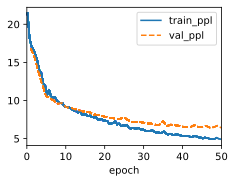

In [5]:

#######
# GRU #
#######

class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

# nn.GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html


'it has a core and has a co'

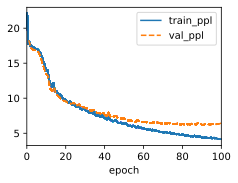

In [6]:

#############
# Deep RNNs #
#############

# Difference comparing to RNN: add "num_layers",also can include a dropout
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

model.predict('it has', 20, data.vocab, d2l.try_gpu())


In [7]:

######################
# Bidirectional RNNs #
######################

class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

In [8]:

#######################
# Machine Translation #
#######################

data = d2l.MTFraEng(batch_size=3)
raw_text = data._download()
print(raw_text[:48])

text = data._preprocess(raw_text)
print(text[:51])

src, tgt = data._tokenize(text)  # len(src), len(tgt): 167130
src[:4]
tgt[:4]

# Vocab for English
VocabE = data.src_vocab
VocabE.idx_to_token[:10]
len(VocabE.idx_to_token)  # 194

# Vocab for French
VocabF = data.tgt_vocab
VocabF.idx_to_token[:10]
len(VocabF.idx_to_token)  # 214

src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
src
tgt
src_valid_len
label
VocabE.to_tokens(src[0].type(torch.int32))
VocabF.to_tokens(tgt[0].type(torch.int32))


Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !

go .	va !
hi .	salut !
run !	cours !
run !	courez !


['<bos>', 'nous', 'avons', 'perdu', '.', '<eos>', '<pad>', '<pad>', '<pad>']

In [9]:
###################################################
# Encoder-Decoder Seq2Seq for Machine Translation #
###################################################
# Vocab size = 20, length of each word representation = 4
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
embed.weight                                 # learnable, generated from N(0,1)

# Example x
x = torch.tensor([[1, 2, 3], [4, 5, 6]])     # just selecting rows 1 to 6
embed(x)  #[1,2,3]rows from the weight matrix,[4,5,6]rows from the weight matrix


tensor([[[ 0.7176, -0.5548,  2.3298,  0.7179],
         [-0.5017, -0.6964, -1.2779, -0.3872],
         [ 0.5646, -0.8613, -0.0124, -0.2952]],

        [[ 0.4023,  0.6328,  1.4812, -0.6965],
         [ 1.1506,  1.5064,  0.7195, -0.5438],
         [ 0.9753,  0.6632, -1.4346, -0.4224]]], grad_fn=<EmbeddingBackward0>)

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


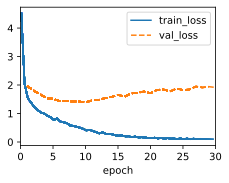

In [10]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros(batch_size, num_steps)
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (num_steps, batch_size, num_hiddens))   # like enc_outputs
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))  # like enc_state

# Train the model
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(len(VocabE), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(VocabF), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder,  lr=0.005, tgt_pad=data.tgt_vocab['<pad>'])
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

# Prediction
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)

for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>': break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')
